In [1]:
!pip install torch==2.2
!pip install torchvision==0.17
!pip install nltk==3.7

In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.use_deterministic_algorithms(True)

#### Dataset information
- There are 240 training images and 150 validation images divided equally between the two classes (bees and ants). 
- We download the dataset from this link - https://www.kaggle.com/ajayrana/hymenoptera-data and store it in the current working directory. 
- In order to download the dataset you will need to login to kaggle. If you do not already have a kaggle account, you will need to register.
- More information about the dataset can be found here: https://hymenoptera.elsiklab.missouri.edu/

In [21]:
ddir = 'hymenoptera_data'

# Data normalization and augmentation transformations for train dataset
# Only normalization transformation for validation dataset
# The mean and std for normalization are calculated as the mean of all pixel values for all images in the training set per each image channel - R, G and B

data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])]),
    'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])])}

img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']}
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True) 
            for k in ['train', 'val']}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

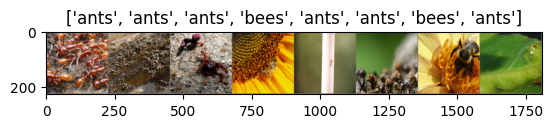

In [22]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

# Generate one train dataset batch
imgs, cls = next(iter(dloaders['train']))

# Generate a grid from batch
grid = torchvision.utils.make_grid(imgs)

imageshow(grid, text=[classes[c] for c in cls])

In [5]:
def finetune_model(pretrained_model, loss_func, optim, epochs=10):
    start = time.time()

    model_weights = copy.deepcopy(pretrained_model.state_dict())
    accuracy = 0.0

    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)

        # for each epoch we run through the training and validation set
        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()  # set model to train mode (i.e. trainbale weights)
            else:
                pretrained_model.eval()   # set model to validation mode

            loss = 0.0
            successes = 0

            # iterate over the (training/validation) data.
            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optim.zero_grad()
                
                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    # backward pass only if in training mode
                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(pretrained_model.state_dict())
        print()

    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
    print(f'Best validation set accuracy: {accuracy}')

    # load the best model version (weights)
    pretrained_model.load_state_dict(model_weights)
    return pretrained_model

In [6]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            tgts = tgts.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)
            
            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

In [7]:
model_finetune = models.alexnet(pretrained=True)
print(model_finetune.features)

c:\projetos\ia\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projetos\ia\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Manoel/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


100.0%


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [8]:
print(model_finetune.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [12]:
# change the last layer from 1000 classes to 2 classes
model_finetune.classifier[6] = nn.Linear(4096, len(classes))

loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(model_finetune.parameters(), lr=0.0001)

# train (fine-tune) and validate the model
model_finetune = finetune_model(model_finetune, loss_func, optim_finetune, epochs=10)

Epoch number 0/9
train loss in this epoch: 0.6879612920714206, accuracy in this epoch: 0.5901639344262295
val loss in this epoch: 0.551454564032991, accuracy in this epoch: 0.7516339869281046

Epoch number 1/9
train loss in this epoch: 0.5484677983112023, accuracy in this epoch: 0.6926229508196722
val loss in this epoch: 0.4693107143336651, accuracy in this epoch: 0.7973856209150327

Epoch number 2/9
train loss in this epoch: 0.46314308291575945, accuracy in this epoch: 0.7786885245901639
val loss in this epoch: 0.4213646145817501, accuracy in this epoch: 0.8169934640522876

Epoch number 3/9
train loss in this epoch: 0.4426530443254064, accuracy in this epoch: 0.8155737704918032
val loss in this epoch: 0.389522474575666, accuracy in this epoch: 0.8300653594771242

Epoch number 4/9
train loss in this epoch: 0.3999530614399519, accuracy in this epoch: 0.8360655737704918
val loss in this epoch: 0.3680268007945391, accuracy in this epoch: 0.8366013071895425

Epoch number 5/9
train loss in 

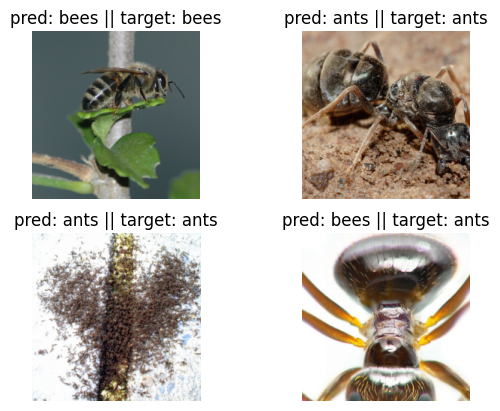

In [23]:
visualize_predictions(model_finetune)

In [16]:
torch.save(model_finetune.state_dict(), 'alexnet_finetuned.pth')

In [17]:
model_finetune = models.alexnet(pretrained=False)  # agora sem os pesos do ImageNet
model_finetune.classifier[6] = nn.Linear(4096, len(classes))  # garantir a saída correta
model_finetune.load_state_dict(torch.load('alexnet_finetuned.pth'))
model_finetune.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 